In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier

scaler = StandardScaler()

In [8]:
data = pd.read_csv('connectome_data.csv')
data = data.drop(columns=['node_id', 'dn_position_x', 'dn_position_y', 'dn_position_z', 'dn_region', 'dn_hemisphere', 'dn_correspondence_id', 'dn_name'])
data['dn_fsname'] = [label.split('_')[0] for label in data['dn_fsname']]

In [9]:
num_evecs = [0,2,10,20,50,80]
best_models = []

for i in num_evecs:
    print(f'Including smallest {i} eigenvectors')
    df = data.drop(columns=[f'evec{i+1}' for i in range(i,150)])
    X = df.drop(columns=['dn_fsname'])
    y = df['dn_fsname']

    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=22)

    model = XGBClassifier(random_state=22)

    param_dist = {
        "n_estimators": [50, 100, 150],
        "max_depth": [6, 10, 12, 14, 16],
        "subsample": [0.5, 0.6, 0.7, 0.8],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, scoring='accuracy', n_iter=5, cv=cv, random_state=22, n_jobs=-1, verbose=3
    )
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, best_model.predict(X_train))
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")

    best_models.append({
        'model': best_model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'num_evecs': i
    })

Including smallest 0 eigenvectors
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 4/5] END max_depth=14, n_estimators=50, subsample=0.6;, score=0.193 total time= 3.5min
[CV 2/5] END max_depth=14, n_estimators=50, subsample=0.6;, score=0.193 total time= 3.5min
[CV 5/5] END max_depth=14, n_estimators=50, subsample=0.6;, score=0.194 total time= 3.6min
[CV 3/5] END max_depth=14, n_estimators=50, subsample=0.6;, score=0.192 total time= 3.6min
[CV 1/5] END max_depth=14, n_estimators=50, subsample=0.6;, score=0.195 total time= 3.6min
[CV 5/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.196 total time= 5.9min
[CV 2/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.194 total time= 5.9min
[CV 3/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.193 total time= 5.9min
[CV 4/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.194 total time= 5.9min
[CV 1/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.195 total time

/Users/shamanthk/Documents/Research/IS-modeling-connectomes/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.251 total time= 6.3min
[CV 3/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.251 total time= 6.3min
[CV 4/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.249 total time= 6.3min
[CV 2/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.250 total time= 6.3min
[CV 1/5] END max_depth=12, n_estimators=100, subsample=0.7;, score=0.251 total time= 6.3min
[CV 1/5] END max_depth=10, n_estimators=50, subsample=0.5;, score=0.255 total time= 2.5min
[CV 2/5] END max_depth=10, n_estimators=50, subsample=0.5;, score=0.255 total time= 2.7min
[CV 4/5] END max_depth=10, n_estimators=50, subsample=0.5;, score=0.253 total time= 2.7min
[CV 5/5] END max_depth=10, n_estimators=50, subsample=0.5;, score=0.253 total time= 2.7min
[CV 3/5] END max_depth=10, n_estimators=50, subsample=0.5;, score=0.256 total time= 2.8min
[CV 1/5] END max_depth=6, n_estimators=100, subsample=0.7;, score=0.261 total time= 3

In [10]:
from joblib import dump, load

dump(best_models, './trained_models/multiclass_models')

['./trained_models/multiclass_models']

In [11]:
train_acc_list = [model['train_acc'] for model in best_models]

test_acc_list = [model['test_acc'] for model in best_models]

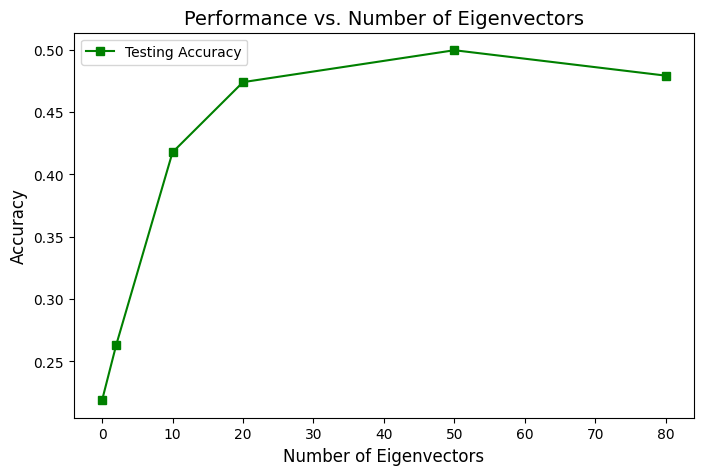

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(num_evecs, test_acc_list, marker='s', label='Testing Accuracy', color='green')

plt.xlabel('Number of Eigenvectors', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Performance vs. Number of Eigenvectors', fontsize=14)
plt.legend()

plt.show()

In [14]:
test_acc_list

[0.2188564752228142,
 0.2630828801605119,
 0.4177529560733314,
 0.4739994005272913,
 0.4996054490845807,
 0.4792233769888119]

In [20]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

misclassified_info = []

for model_info in best_models:
    num_evecs = model_info['num_evecs']
    best_model = model_info['model']
    
    print(f"\nAnalyzing errors for model with {num_evecs} smallest eigenvectors:")
    
    # Drop eigenvectors not included
    selected_columns = [col for col in data.columns if not col.startswith('evec') or int(col[4:]) <= num_evecs]
    df = data[selected_columns]
    X = df.drop(columns=['dn_fsname'])
    y = df['dn_fsname']

    # Normalize features and encode labels
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split again to match the same test set
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=22
    )
    
    # Predictions
    y_pred = best_model.predict(X_test)

    # Identify misclassified indices
    misclassified_indices = np.where(y_pred != y_test)[0]
    misclassified_classes = y_test[misclassified_indices]
    predicted_classes = y_pred[misclassified_indices]

    # Collect information about misclassified nodes
    misclassified_df = pd.DataFrame({
        'True Class': label_encoder.inverse_transform(misclassified_classes),
        'Predicted Class': label_encoder.inverse_transform(predicted_classes),
        'Node Index': misclassified_indices
    })
    
    # Aggregate counts per class
    class_errors = Counter(misclassified_df['True Class'])
    print("Errors per class:")
    for cls, count in class_errors.items():
        print(f"  {cls}: {count} errors")
    
    # Save misclassified information
    misclassified_info.append({
        'num_evecs': num_evecs,
        'errors': class_errors,
        'misclassified_df': misclassified_df
    })

# Example: Display misclassified nodes for the first model
print("\nExample Misclassified Nodes for the First Model:")
print(misclassified_info[0]['misclassified_df'])


Analyzing errors for model with 0 smallest eigenvectors:
Errors per class:
  precentral: 10785 errors
  postcentral: 8455 errors
  lingual: 5931 errors
  cuneus: 2914 errors
  inferiorparietal: 7580 errors
  fusiform: 4840 errors
  supramarginal: 7946 errors
  parsopercularis: 3784 errors
  transversetemporal: 1101 errors
  superiorfrontal: 7184 errors
  superiortemporal: 3140 errors
  caudalmiddlefrontal: 4204 errors
  insula: 3887 errors
  superiorparietal: 10201 errors
  precuneus: 8368 errors
  rostralmiddlefrontal: 6361 errors
  posteriorcingulate: 2633 errors
  inferiortemporal: 2261 errors
  middletemporal: 2255 errors
  medialorbitofrontal: 189 errors
  lateralorbitofrontal: 768 errors
  bankssts: 2282 errors
  parahippocampal: 1187 errors
  isthmuscingulate: 1954 errors
  pericalcarine: 3012 errors
  Left-Hippocampus: 123 errors
  caudalanteriorcingulate: 1879 errors
  paracentral: 4201 errors
  Left-Accumbens-area: 103 errors
  parstriangularis: 1519 errors
  Right-Amygdala:

In [27]:
data = pd.read_csv('connectome_data.csv')

In [28]:
data['misclassified'] = False

# Retrieve the misclassified indices from the misclassified DataFrame
misclassified_indices = misclassified_df['Node Index'].values

# Set 'misclassified' to True for rows corresponding to misclassified indices
data.loc[misclassified_indices, 'misclassified'] = True

# Verify the result
print(data[['misclassified']].value_counts())
print(data.loc[misclassified_indices])

misclassified
False            732247
True              85135
Name: count, dtype: int64
        dn_position_x  dn_position_y  dn_position_z  dn_correspondence_id  \
1           21.815217      74.641304      22.744565                    43   
5           22.843750      70.507812      15.437500                    48   
6           25.027027      69.621622      20.445946                    49   
7           27.387500      72.312500      21.800000                    50   
8           28.831325      68.578313      22.638554                    51   
...               ...            ...            ...                   ...   
163465      63.672269      58.756303      32.344538                   744   
163467      65.901961      54.421569      33.372549                   746   
163468      71.532934      55.766467      35.886228                   747   
163475      71.920904      48.146893      37.689266                   754   
163476      68.987097      53.141935      37.335484              

In [29]:
data.head()

,dn_position_x,dn_position_y,dn_position_z,dn_correspondence_id,dn_region,dn_fsname,dn_name,dn_hemisphere,node_id,deg_cent,...,evec142,evec143,evec144,evec145,evec146,evec147,evec148,evec149,evec150,misclassified
0,29.076923,74.990385,15.028846,37,cortical,parstriangularis_3,rh.parstriangularis_3,right,37,0.002759,...,0.000362,-0.000637,0.000503,-0.000857,-0.000461,0.000357,0.000304,0.000648,-0.000686,False
1,21.815217,74.641304,22.744565,43,cortical,parsopercularis_8,rh.parsopercularis_8,right,43,0.001379,...,0.002545,-0.004542,0.003605,-0.006211,-0.003367,0.002626,0.002280,0.004881,-0.005242,True
2,27.840580,71.246377,17.188406,45,cortical,parsopercularis_5,rh.parsopercularis_5,right,45,0.038621,...,0.019512,-0.022062,0.018583,0.001991,-0.006282,0.005656,-0.013887,0.004871,-0.022915,False
3,30.631579,71.726316,19.010526,46,cortical,parsopercularis_9,rh.parsopercularis_9,right,46,0.102069,...,-0.022290,-0.005628,0.025643,0.017672,0.029580,0.015303,0.036505,0.020346,-0.093865,False
4,24.845528,69.032520,14.040650,47,cortical,parsopercularis_3,rh.parsopercularis_3,right,47,0.004138,...,0.032983,-0.048004,0.049949,-0.046214,-0.008345,0.036741,0.025997,0.064640,-0.095186,False


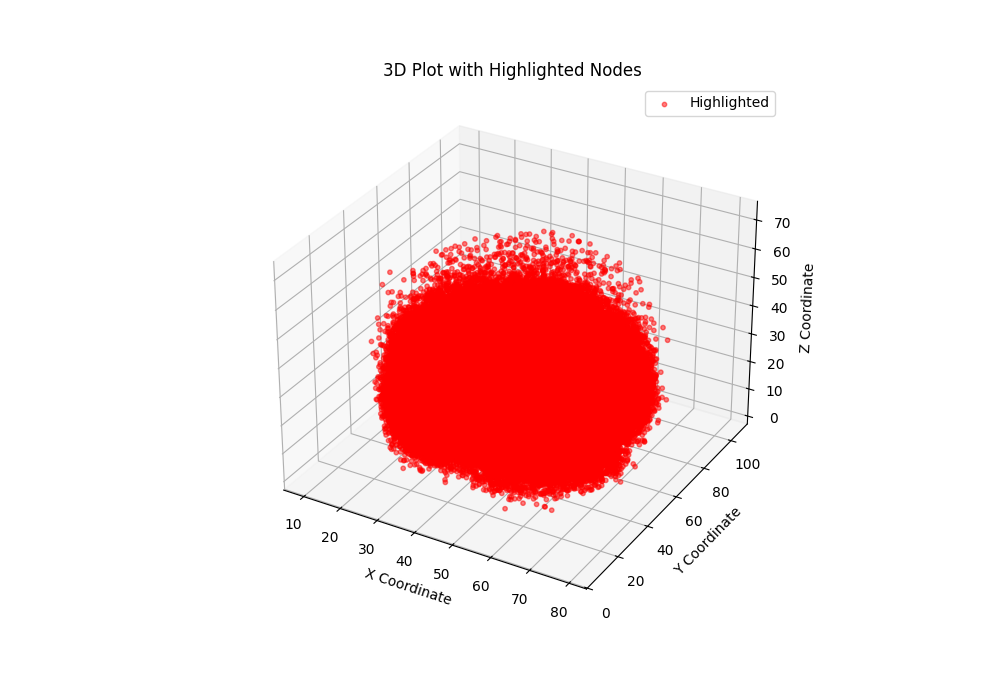

In [35]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample Dataset (replace this with your dataset)
# Example format:
# data = {'x': [1, 2, 3, 4],
#         'y': [2, 3, 4, 5],
#         'z': [3, 4, 5, 6],
#         'highlight': [True, False, True, False]}
df = pd.DataFrame(data)

# Create the 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the nodes
# Highlighted nodes in a different color
highlighted = df[df['misclassified'] == True]
non_highlighted = df[df['misclassified'] == False]


# Plot highlighted nodes
ax.scatter(highlighted['dn_position_x'], highlighted['dn_position_y'], highlighted['dn_position_z'], 
           color='red', label='Highlighted', alpha=0.5, s=10)

# Add labels and legend
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Plot with Highlighted Nodes')
ax.legend()

# Show the plot
plt.show()